<a href="https://colab.research.google.com/github/tumble-weed/style-transfer/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For colab, have to reinstall pillow

In [1]:
if 'collab':
    !pip install -I --no-cache-dir pillow

     |████████████████████████████████| 2.0MB 2.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
import torch,torchvision
import numpy as np 
from matplotlib import pyplot as plt
import os

from PIL import Image
from skimage import io

import copy

tensor_to_numpy = lambda t:t.detach().cpu().numpy() 
device = 'cuda' if torch.cuda.is_available else 'cpu' #for gpu

get the data from the pytorch site

In [3]:
!wget -nc --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate  'https://docs.google.com/uc?export=download&id=1W_ZTjbaJQt8352u06oRn7Xea1F5zgZx-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1W_ZTjbaJQt8352u06oRn7Xea1F5zgZx-" -O scream.jpeg && rm -rf /tmp/cookies.txt
!wget -nc --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate  'https://docs.google.com/uc?export=download&id=1bLjo3Rsg5fwaRHSInmtgkObCa6JHGrR9' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1bLjo3Rsg5fwaRHSInmtgkObCa6JHGrR9" -O girl_on_bridge.jpg && rm -rf /tmp/cookies.txt

File ‘scream.jpeg’ already there; not retrieving.
File ‘girl_on_bridge.jpg’ already there; not retrieving.


Model specifications and transform:
sizes of images, mean and variance

In [0]:
model_specs = {'alexnet':(227,227),
              'vgg19':(224,224),
              }
model_name = 'vgg19'
mean,std = (0.485, 0.456, 0.406),(0.229, 0.224, 0.225)
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(model_specs[model_name]),
                                            torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                                              std=(0.229, 0.224, 0.225)),
                                            ])


See the images

Text(0.5, 1.0, 'Girl On Bridge')

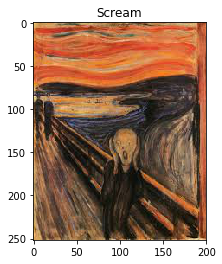

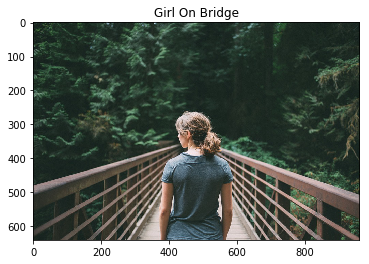

In [5]:
im_scream,im_bridge_girl = io.imread('scream.jpeg'), io.imread('girl_on_bridge.jpg')

plt.figure()
plt.imshow(im_scream)
plt.title('Scream')

plt.figure()
plt.imshow(im_bridge_girl)
plt.title('Girl On Bridge')

make tensors from images, resizing and transforming them.

In [0]:
im_scream_pil,im_bridge_girl_pil = Image.fromarray(im_scream),Image.fromarray(im_bridge_girl)

scream = transforms(im_scream_pil).unsqueeze(0)
bridge_girl = transforms(im_bridge_girl_pil).unsqueeze(0)

Define functions for converting the input to the CNN back into a visualizable image

In [0]:
def denormalize_tensor(t,
                       mean = [0.5,0.5,0.5],
                       std = [0.5,0.5,0.5]):
    
    mean = torch.tensor(mean).float().unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    std = torch.tensor(std).float().unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    
    mean = mean.type_as(t).to(t.device)
    std = std.type_as(t).to(t.device)
    
    dnrm_t = t * std + mean
    return dnrm_t
    
def tensor_to_im(t,
                 mean = mean,
                 std=std):
    t = denormalize_tensor(t,
                           mean=mean,
                           std=std)
    t_np = tensor_to_numpy(t)
    im = np.transpose(t_np,(0,2,3,1))
    return im

if not 'test':
    plt.figure()
    plt.imshow(im_scream)
    plt.title('original')
    
    im1 = tensor_to_im(scream)
    im1 = im1[0]
    plt.figure()
    plt.imshow(im1)
    plt.title('from tensor')

Make a Gram Matrix

In [0]:
def gram_matrix(t):
    b,c,h,w = t.shape
    f = t.view(b,c,-1)
    g = torch.einsum('bxf,bzf ->bxz',[f,f])
    g = g/np.prod(t.shape) # to account for difference in number of channels and pixels at every layer of the CNN
    return g
if not 'test':
    t = torch.zeros(2,64,5,5)
    t[:,0,:,:] = 1
    t[:,1,:,:] = 1
    g = gram_matrix(t)
    
    print(g.shape,'\n',
          g[0][:4,:4])
    

Get the model

In [0]:
model = torchvision.models.vgg19(pretrained=True).features.to(device).eval() # get the model in eval mode

**questions**
- relu or pre-relu for the layers: **pre-relu**
- wouldn't simple backward hooks work? **yes**

**-**

- Declare the variables to be used for the content and the style losses,
- attach hooks to those layers

In [0]:
def fwdHook(self,input,output):
    self.feat = output
    pass
if model_name == 'vgg19':
    layers_for_style = [0,
                        2,
                        5,
                        7,
                        10]
    layers_for_content = [0]

layers_of_interest = layers_for_style[:]
layers_of_interest.extend(layers_for_content[:])

hooked_layers = []
model_children = list(model.children())
for li in layers_of_interest:
    l = model_children[li]
    hooked_layers.append(l.register_forward_hook(fwdHook))



Declare the style and content images,  the optimizee and the optimizer

In [0]:
content,style = bridge_girl,scream
output = content.detach().clone() # the output starts from the content image
content,style,output = content.to(device),style.to(device),output.to(device) # push everything onto the device
output = output.requires_grad_(True) # requires_grad should be the last operation on the optimizee 
# opt = torch.optim.LBFGS([output]) # similar to the tutorial, using a L-BFGS optimizer
opt = torch.optim.Adam([output],
                      lr = 1e-2)

Optimization loop and visualization

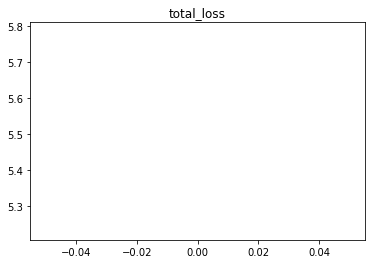

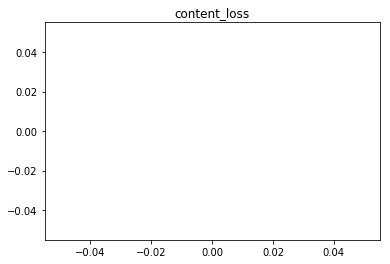

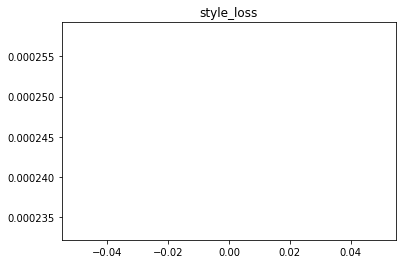

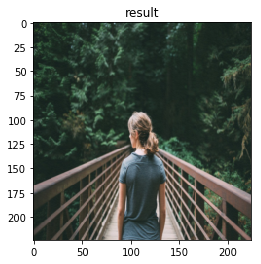

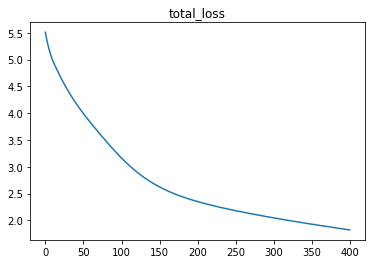

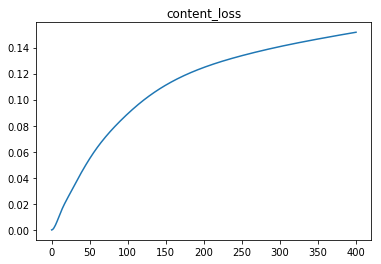

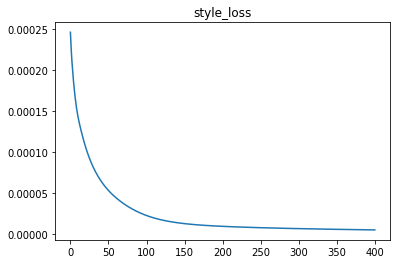

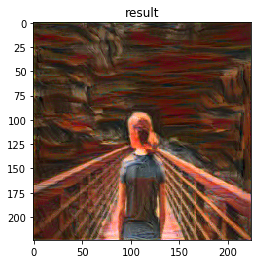

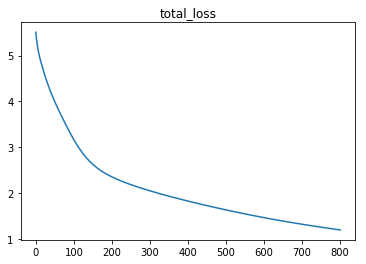

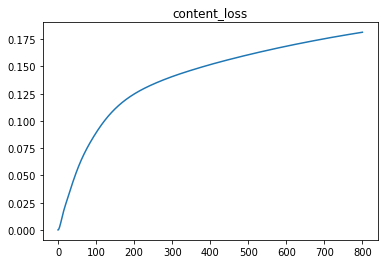

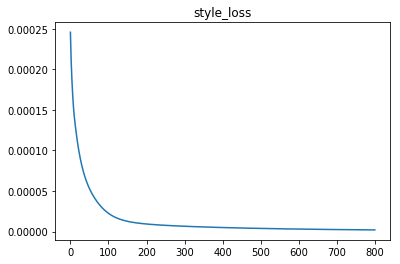

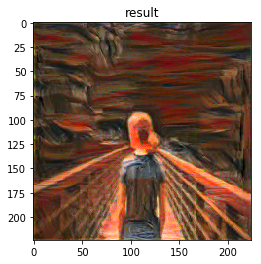

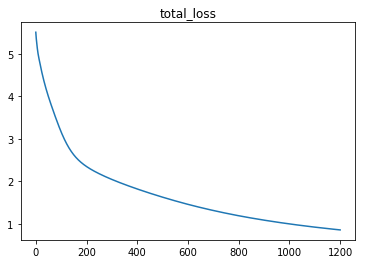

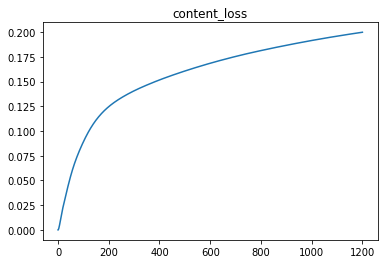

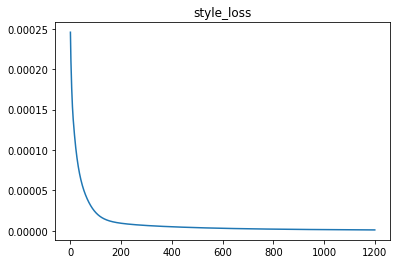

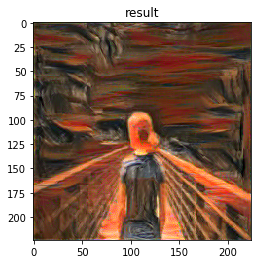

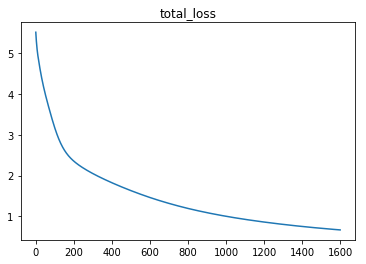

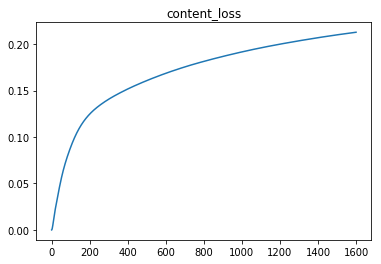

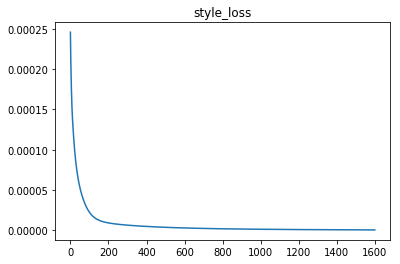

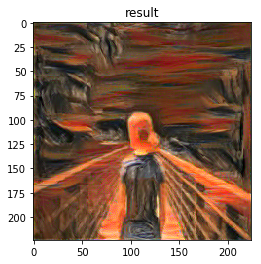

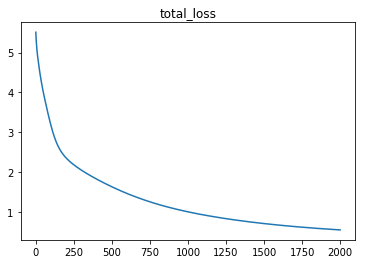

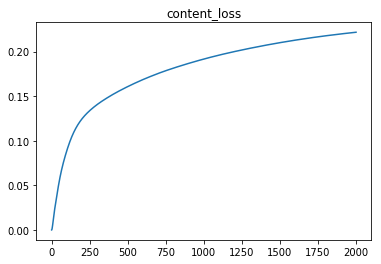

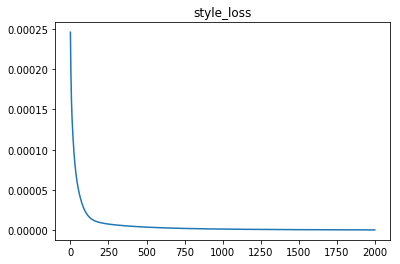

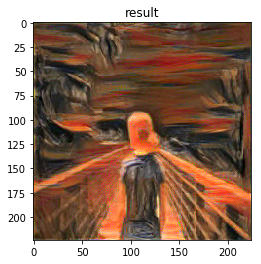

In [18]:
nepochs  = 2400
vis_every = 400

trends = {'total_loss':[],
         'content_loss':[],
         'style_loss':[],}
style_lambda = 1000000 
for e in range(nepochs):
    
    '''----- style -----'''
    _ = model(style) # pass the style image through the CNN
    style_feat = [model_children[li].feat for li in layers_for_style] # get the feats from the style layers    
    style_gram = [gram_matrix(f) for f in style_feat] # calculate the gram matrix over these layers
    
    '''----- content -----'''
    _ = model(content) # pass the content image through the CNN

    content_feat = model_children[layers_for_content[0]].feat  # there is only one content layer
    
    '''----- output -----'''
    _ = model(output) # pass the optimizee through the CNN
    output_style_feat = [model_children[li].feat for li in layers_for_style]     # get the optimizee style feats
    output_style_gram = [gram_matrix(f) for f in output_style_feat] # get the optimizee gram matrices
#     output_content_feat = [model_children[li].feat for li in layers_for_content]
    output_content_feat = model_children[layers_for_content[0]].feat # get the optimizee content features
    
    '''----- losses -----'''
    content_loss = torch.nn.functional.mse_loss(content_feat.view(-1),output_content_feat.view(-1))  
    style_loss = sum([torch.nn.functional.mse_loss(st_gr.view(-1),op_gr.view(-1))  for st_gr,op_gr in zip(style_gram,output_style_gram)])
    total_loss = content_loss + style_lambda * style_loss
    
    '''----- update -----'''
    opt.zero_grad()
    total_loss.backward()
    opt.step()
    
    '''----- bookkeeping -----'''
    trends['total_loss'].append(tensor_to_numpy(total_loss))
    trends['content_loss'].append(tensor_to_numpy(content_loss))
    trends['style_loss'].append(tensor_to_numpy(style_loss))
    
    '''----- visualization -----'''
    if e%vis_every==0:
        
        for nm,ls in trends.items():
            plt.figure()
            plt.plot(np.arange(len(ls)),np.log1p(ls)) # choosing to do log(1 + loss) as the losses tend to become really high as well as low
            plt.title(nm)
            plt.show()
    
        plt.figure()
        plt.imshow(tensor_to_im(output)[0])
        plt.title('result')
        plt.show()
    pass

In [19]:
if 'save_to_disk':
    result = tensor_to_im(output)[0]
    io.imsave('style_transferred.jpg',result)
